# Make All Figures for Main Manuscript

Kendra Wyant  
February 19, 2025

In [ ]:
#| message: false
#| warning: false

suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(source("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true"))
suppressPackageStartupMessages(library(tidyposterior))
library(kableExtra, exclude = "group_rows")
library(patchwork)

theme_set(theme_classic())

path_models_lag <- format_path(str_c("studydata/risk/models/lag"))
path_shared <- format_path("studydata/risk/data_processed/shared")
path_processed <- format_path("studydata/risk/data_processed/lag")

Data for figures

In [ ]:
pp_tidy <- read_csv(here::here(path_models_lag, "posteriors.csv"), 
                                 show_col_types = FALSE) 

ci <- read_csv(here::here(path_models_lag, "pp_perf_tibble.csv"), 
                                 show_col_types = FALSE) |> 
  mutate(model = factor(model, levels = c("0 lag", "24 lag", "72 lag", "168 lag", "336 lag"),
                        labels = c("No lag", "1 day", "3 days", "1 week", "2 weeks")))

global_all <- read_rds(here::here(path_models_lag, "shap_global_all.rds")) |> 
   filter(str_detect(variable_grp, "EMA")) |> 
   mutate(variable_grp = str_remove(variable_grp, "\\(EMA item\\)"),
          variable_grp = reorder(variable_grp, mean_value, sum),
          model = factor(model, levels = c("336 lag", "168 lag", "72 lag", "24 lag", "0 lag"),
                         labels = c("2 weeks", "1 week", "3 days", "1 day", "No lag" ))) |> 
  filter(model %in% c("2 weeks", "No lag"))

shap_levels <- global_all |>
  mutate(variable_grp = reorder(variable_grp, mean_value, sum)) |>
  pull(variable_grp) |>
  levels()

## Figure 1: Prediction Methods

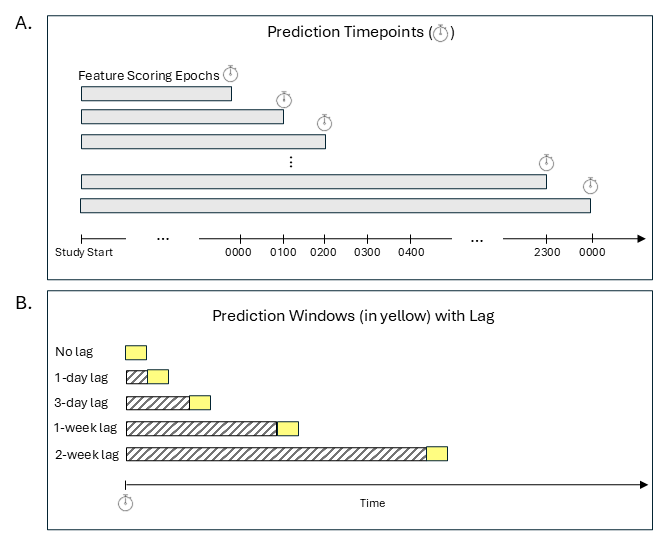

In [ ]:
#| label: fig-method
#| fig-cap: "Panel A shows the prediction timepoints at which our model calculated a predicted probability of a lapse. All available data up until, but not including, the prediction timepoint was used to generate these predictions. Features were created for varying feature scoring epochs before the prediction timepoint (i.e., 12, 24, 48, 72, and 168 hours). Prediction timepoints were updated hourly. Panel B shows how the prediction window (i.e., window in which a lapse might occur) rolls forward hour-by-hour with the prediction timepoint. The prediction window width for all models was 24 hours. Additionally, there were five possible lag times between the prediction timepoint and start of the prediction window. A prediction window either started immediately after the prediction timepoint (no lag) or was lagged by 1 day, 3 days, 1 week, or 2 weeks."

knitr::include_graphics(path = here::here("figures/methods.png"), error = FALSE)

## Figure 2: Posterior probabilities for auROC by model

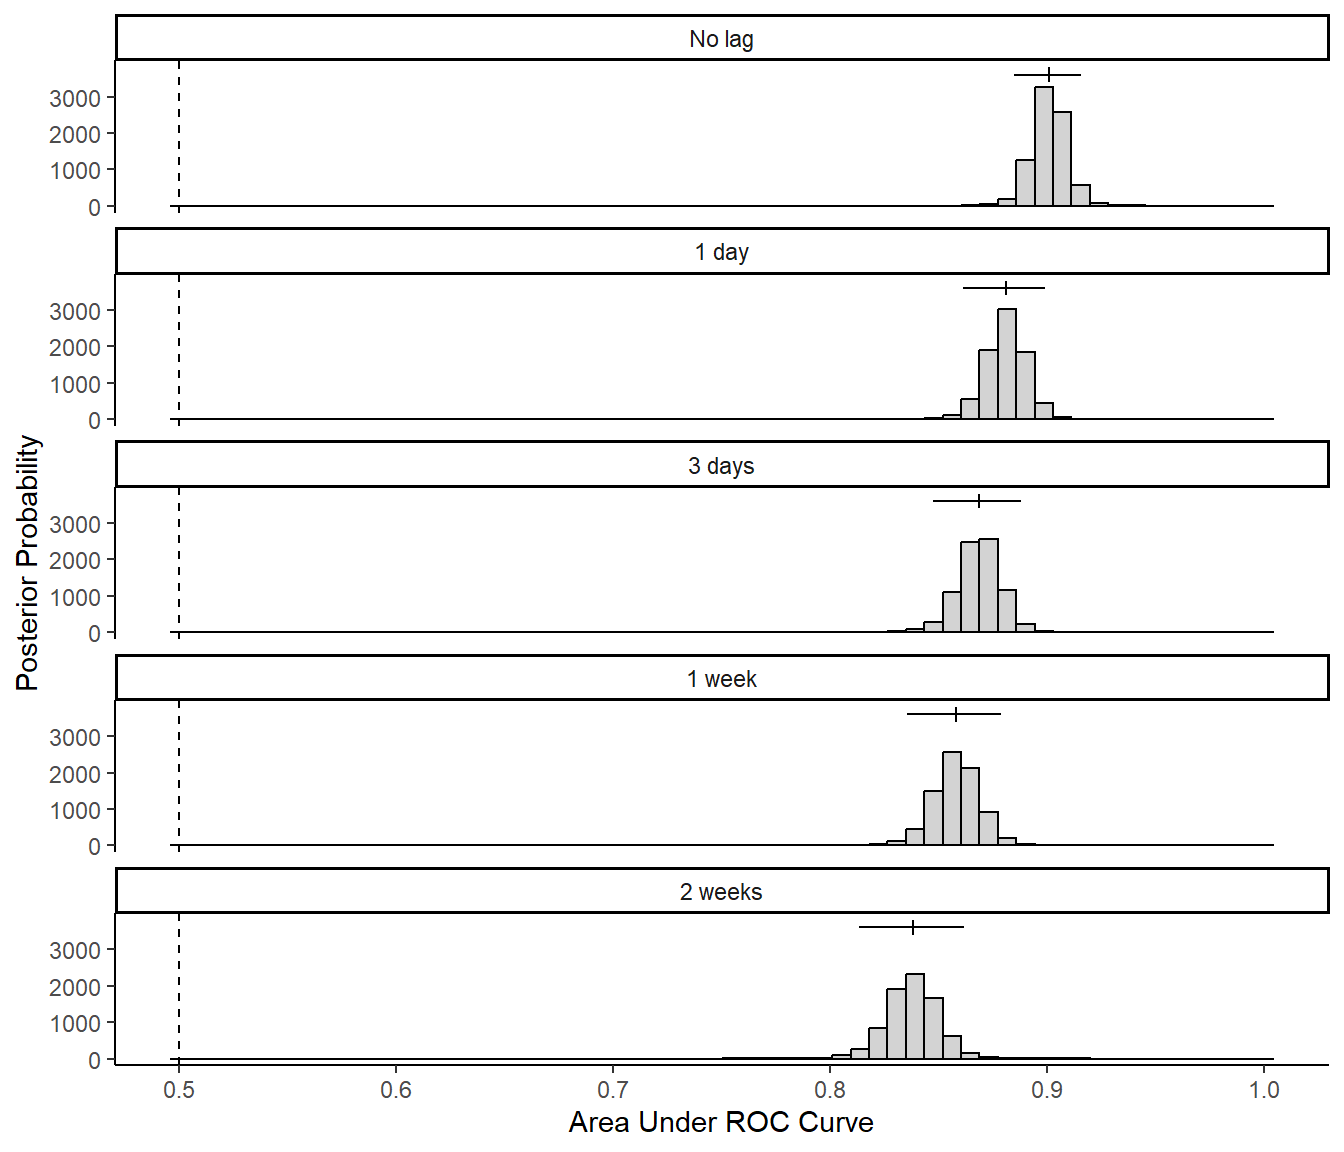

In [ ]:
#| label: fig-pp
#| fig-cap: "Posterior probability distributions for area under ROC curve (auROC) for each model (no lag, 1-day, 3-day, 1-week, and 2-week lag). Horizonatal lines depict 95% Bayesian credible intervals (CI) and vertical solid lines depict median posterior probability for auROC. Vertical dashed line represents expected performance from a random classifier (.5 auROC)."
#| fig-width: 7
#| fig-height: 6

pp_tidy |> 
  mutate(model = factor(model, levels = c("lag0", "lag24", "lag72", "lag168", "lag336"),
                        labels = c("No lag", "1 day", "3 days", "1 week", "2 weeks"))) |>
  ggplot() + 
  geom_histogram(aes(x = posterior), fill = "light grey", color = "black", linewidth = .5,  
                 bins = 60) +
  geom_segment(mapping = aes(y = 3400, yend = 3800, x = pp_median, xend = pp_median),
               linewidth = .5, data = ci) +
  geom_segment(mapping = aes(y = 3600, yend = 3600, x = pp_lower, xend = pp_upper),
                linewidth = .5, data = ci) +
  facet_wrap(~model, ncol = 1) +
  geom_vline(xintercept = .5, linewidth = .5, linetype = "dashed") +
  scale_y_continuous("Posterior Probability") +
  xlab("Area Under ROC Curve") +
  expand_limits(x = c(.5, 1)) +
  theme_classic() 

## Figure 3: Global and Local Shapley Plots

In [ ]:
global_panel <- global_all |>
  ggplot() +
  geom_bar(aes(x = variable_grp, y = mean_value, fill = model), 
           stat = "identity", position = "dodge") +
  labs(y = "Mean(|Shapley Value|)",
       x = NULL,
       fill = NULL) +
  scale_fill_manual(values = c("#458892", "#751c6d")) +
  theme(axis.text=element_text(size=9.5),
        legend.key.size = unit(0.25, "cm"),
        panel.border = element_rect(colour = "black", fill = NA, linewidth = 1),
        legend.position = "right") +
  coord_flip()

In [ ]:
shap_feat_0 <- read_rds(here::here(path_models_lag, 
                                   "outer_shapsgrp_1day_0_v3_nested_main.rds")) |> 
  filter(str_detect(variable_grp, "EMA")) |> 
  mutate(variable_grp = str_remove(variable_grp, "\\(EMA item\\)"),
         variable_grp = factor(variable_grp, levels = shap_levels)) |> 
  group_by(variable_grp) |> 
  summarize(min(value), max(value)) |> 
  mutate(model = "No lag")

shap_feat_336 <- read_rds(here::here(path_models_lag, 
                                     "outer_shapsgrp_1day_336_v3_nested_main.rds")) |> 
  filter(str_detect(variable_grp, "EMA")) |> 
  mutate(variable_grp = str_remove(variable_grp, "\\(EMA item\\)"),
         variable_grp = factor(variable_grp, levels = shap_levels))  |> 
  group_by(variable_grp) |> 
  summarize(min(value), max(value)) |> 
  mutate(model = "2 weeks")

panel_shap_local <- shap_feat_0 |>
  bind_rows(shap_feat_336) |> 
  mutate(model = factor(model, levels = c("2 weeks", "No lag"))) |> 
  rename(min = `min(value)`,
         max = `max(value)`) |> 
  ggplot() +
  geom_segment(aes(x = variable_grp, y = min, yend = max, group = model,
                   color = model),
               position = position_dodge(width = .5), 
               linewidth = 1) +
  ylab("Raw Shapley Value") +
  xlab(NULL) +
  labs(color = NULL) +
  scale_color_manual(values = c("#458892", "#751c6d")) +
  theme(legend.position = "none",
        axis.text=element_text(size=9.5),
        panel.border = element_rect(colour = "black", fill = NA, 
                                    linewidth = 1))+
  geom_hline(aes(yintercept = 0), linetype = "dashed",
             linewidth = .5) +
  scale_y_continuous(limits = c(-2, 6), breaks = seq(-2, 6, 2)) +
  coord_flip()

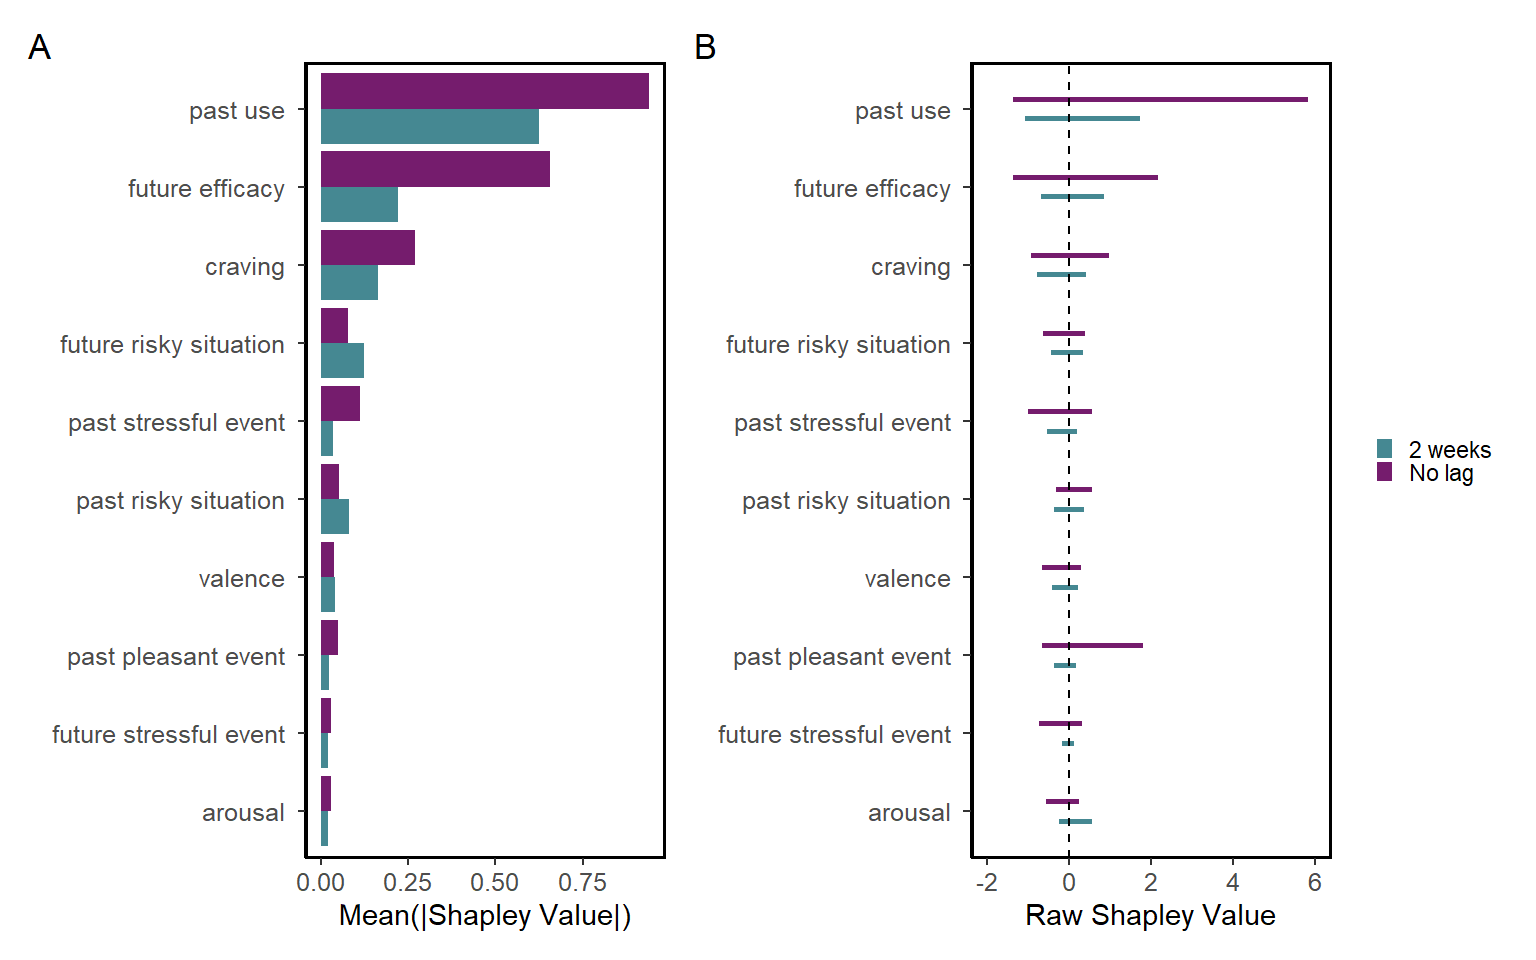

In [ ]:
#| label: fig-3
#| fig-cap: "Panel A displays the global importance (mean |Shapley value|) for feature categories for the no lag and 2-week lag models. Feature categories are ordered by their aggregate global importance. The importance of each feature category for each model is displayed separately by color. Panels B displays the variation in local feature importance for the no lag and 2-week lag models. Lines start at minimum Shapley value and end at maximum Shapley value."
#| fig-width: 8
#| fig-height: 5

global_panel + panel_shap_local + 
  plot_layout(guides = "collect") &
  plot_annotation(tag_levels = "A") 